<a href="https://colab.research.google.com/github/Mehdys/Vasicek-irrbb-modelling/blob/main/Notebooks/Calibration_Vasicek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modélisation des Taux d'Intérêt avec le Modèle de Vasicek
*Introduction*

Ce notebook a pour objectif de modéliser l'évolution des taux d'intérêt en utilisant le modèle stochastique de Vasicek. Le modèle de Vasicek est un modèle de taux court à un facteur largement utilisé en finance. Il décrit l'évolution future des taux d'intérêt comme un processus de retour à la moyenne.

 $ dr_t = a(b - r_t)dt + \sigma dW_t $$

 Où :
 - $r_t$ est le taux d'intérêt au temps $t$.
 - $a$ est la vitesse à laquelle le taux revient à sa moyenne de long terme.
 - $b$ est la moyenne de long terme vers laquelle le taux converge.
 - $\sigma$ est la volatilité du processus.
 - $dW_t$ est un processus de Wiener standard.


*Dans ce travail, nous allons :*

 1. Charger et explorer les données historiques des taux d'intérêt.
 2. Calibrer les paramètres du modèle de Vasicek ($a$, $b$, $\sigma$) à partir des données historiques en utilisant la méthode des Moindres Carrés Ordinaires (OLS) sur la version discrétisée du modèle.
 3. Simuler plusieurs trajectoires de taux d'intérêt en utilisant les paramètres calibrés.
 4. Évaluer la performance du modèle calibré en comparant les trajectoires simulées aux données réelles, notamment via le calcul du Root Mean Square Error (RMSE).


1. Importation des Bibliothèques et Chargement des Données



In [ ]:
from IPython import get_ipython
from IPython.display import display

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
from google.colab import drive

print(os.getcwd())

# %%
# Montage de Google Drive pour accéder au fichier de données
drive.mount('/content/drive')

# %%
# Chargement des données
file_path = '/content/IRR.csv - Sheet1.csv' # <--- Modifie ce chemin si nécessaire
try:
    df = pd.read_csv(file_path, delimiter=',', parse_dates=['date'])
    print("Fichier chargé avec succès.")
except FileNotFoundError:
    print(f"Erreur : Le fichier n'a pas été trouvé à l'emplacement : {file_path}")
    print("Veuillez vérifier le chemin d'accès au fichier CSV.")
    # Sortir ou gérer l'erreur si le fichier n'est pas trouvé


/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fichier chargé avec succès.


Exploration et Préparation des Données :

Colonnes du DataFrame : ['date', 'value']

Premières lignes du DataFrame :


,date,value
0,1970-01-01,10.35
1,1970-02-01,9.86
2,1970-03-01,9.55
3,1970-04-01,8.95
4,1970-05-01,9.02



Informations sur le DataFrame :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    664 non-null    datetime64[ns]
 1   value   664 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.5 KB

Colonne 'value' ajustée (divisée par 100).
DataFrame trié par date.
Variables r_real et dates_real définies.


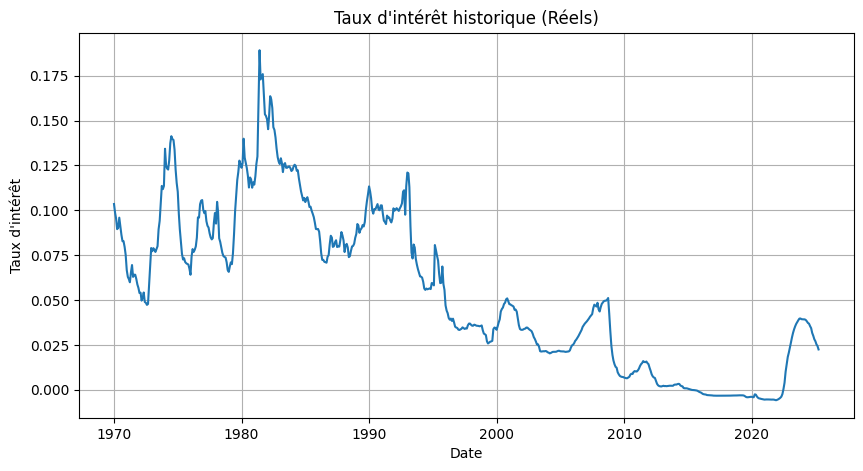

In [ ]:
# Afficher les colonnes pour vérifier les noms
print("Colonnes du DataFrame :", df.columns.tolist())

# Vérifier les premières lignes et types de données
print("\nPremières lignes du DataFrame :")
display(df.head())

print("\nInformations sur le DataFrame :")
df.info()

# Vérifier la colonne des taux
if 'value' in df.columns:
    df['value'] = df['value'] / 100.0  # Diviser par 100 car le taux est en pourcentage
    print("\nColonne 'value' ajustée (divisée par 100).")
else:
    print("\nAvertissement : La colonne 'value' n'a pas été trouvée. Veuillez vérifier le nom de la colonne des taux.")


# Tri des données par date
df = df.sort_values('date').reset_index(drop=True)
print("DataFrame trié par date.")

# Assigner les taux réels et les dates aux variables utilisées dans le modèle
r_real = df['value'].values
dates_real = df['date']
print("Variables r_real et dates_real définies.")


# Visualiser la série temporelle des taux réels
plt.figure(figsize=(10,5))
plt.plot(df['date'], df['value'])
plt.xlabel('Date')
plt.ylabel('Taux d\'intérêt')
plt.title('Taux d\'intérêt historique (Réels)')
plt.grid(True)
plt.show()

 2. Calibration du Modèle de Vasicek (Méthode OLS)

 Nous allons estimer les paramètres $a$, $b$, et $\sigma$ en utilisant une régression OLS sur la forme discrétisée du modèle de Vasicek. La forme discrétisée (avec $\Delta t$) est approximativement :

 $$ r_t - r_{t-1} \approx a(b - r_{t-1})\Delta t + \sigma \sqrt{\Delta t} \epsilon_t $$

 Où $\epsilon_t$ est un terme d'erreur avec une moyenne de 0 et une variance de 1.

 En réarrangeant, on obtient une relation linéaire :

 $$ \Delta r_t \approx (ab\Delta t) + (-a\Delta t) r_{t-1} + \sigma \sqrt{\Delta t} \epsilon_t $$

 Ceci correspond à un modèle de régression linéaire :

 $$ Y_t = \alpha + \beta X_t + \text{erreur}_t $$

 Où :
 - $Y_t = \Delta r_t = r_t - r_{t-1}$ (les différences de taux)
 - $X_t = r_{t-1}$ (le taux au pas de temps précédent)
 - $\alpha = ab\Delta t$
 - $\beta = -a\Delta t$
 - $\text{erreur}_t = \sigma \sqrt{\Delta t} \epsilon_t$

 Une fois $\hat{\alpha}$ et $\hat{\beta}$ estimés par OLS, nous pouvons en déduire :

 - $\hat{a} = -\hat{\beta} / \Delta t$
 - $\hat{b} = -\hat{\alpha} / \hat{\beta}$
 - $\hat{\sigma} = \text{Écart type}(\text{erreurs}) / \sqrt{\Delta t}$ (où les erreurs sont les résidus de la régression)


In [ ]:
# Calcul des différences de taux (Δr_t) et des taux retardés (r_{t-1})
delta_r = np.diff(r_real)
r_lagged = r_real[:-1]

# Définition du pas de temps (dt)
# Supposons des données quotidiennes ouvrées, donc 250 jours par an
dt = 1/250.0

print(f"Nombre de points de données pour la régression : {len(r_lagged)}")
print(f"Pas de temps (dt) : {dt:.4f} années")

# Construction du modèle de régression linéaire
X = sm.add_constant(r_lagged)  # ajoute une colonne de 1 pour l'intercept α
model = sm.OLS(delta_r, X)

# Ajustement du modèle
results = model.fit()

# Extraction des coefficients estimés (α et β)
alpha_hat = results.params[0]
beta_hat = results.params[1]

print(f"\n - Alpha estimé : {alpha_hat:.6f}")
print(f" - Beta estimé : {beta_hat:.6f}")

sigma_est = np.std(results.resid, ddof=1) / np.sqrt(dt)


print("\n Paramètres estimés du modèle de Vasicek :")
print(f" - a (vitesse de réversion) : {-beta_hat / dt:.4f}")
print(f" - b (moyenne de long terme) : {-alpha_hat / beta_hat:.4f}")
print(f" - sigma (volatilité) : {sigma_est:.4f}")

# Stocker les valeurs estimées dans des variables pour les simulations
a_est = -beta_hat / dt
b_est = -alpha_hat / beta_hat
sigma_est = sigma_est # Déjà calculé

Nombre de points de données pour la régression : 663
Pas de temps (dt) : 0.0040 années

 - Alpha estimé : 0.000142
 - Beta estimé : -0.004846

 Paramètres estimés du modèle de Vasicek :
 - a (vitesse de réversion) : 1.2114
 - b (moyenne de long terme) : 0.0294
 - sigma (volatilité) : 0.0650


 3. Simulation de Multiples Trajectoires avec les Paramètres Calibrés

In [ ]:
n_simulations = 100

# Listes pour stocker les résultats de chaque simulation
simulated_rmse_list = []
simulated_trajectories = [] # Pour stocker les trajectoires pour la visualisation

# Utiliser les paramètres estimés
a = a_est
b = b_est
sigma = sigma_est

print(f"Génération de {n_simulations} trajectoires avec les paramètres estimés :")
print(f" - a (vitesse de réversion) : {a:.4f}")
print(f" - b (moyenne de long terme) : {b:.4f}")
print(f" - sigma (volatilité) : {sigma:.4f}")
print(f" - Pas de temps (dt) : {dt:.4f}")

# Boucle pour générer les simulations
for i in range(n_simulations):

    # Initialiser et simuler la trajectoire
    current_r_simulated = np.zeros(len(r_real))
    current_r_simulated[0] = r_real[0]  # même point de départ que la série réelle

    for t in range(1, len(r_real)):
        # Formule de discrétisation du modèle de Vasicek
        drift = a * (b - current_r_simulated[t-1]) * dt
        diffusion = sigma * np.sqrt(dt) * np.random.normal(0,1) # Terme aléatoire issu d'une distribution normale
        current_r_simulated[t] = current_r_simulated[t-1] + drift + diffusion

    # Calculer le RMSE pour cette simulation (comparaison avec la série réelle)
    current_rmse = np.sqrt(np.mean((r_real - current_r_simulated)**2))

    # Stocker le RMSE et la trajectoire de cette simulation
    simulated_rmse_list.append(current_rmse)
    simulated_trajectories.append(current_r_simulated) # Stocker la trajectoire complète

print("\nSimulation de trajectoires terminée.")

Génération de 100 trajectoires avec les paramètres estimés :
 - a (vitesse de réversion) : 1.2114
 - b (moyenne de long terme) : 0.0294
 - sigma (volatilité) : 0.0650
 - Pas de temps (dt) : 0.0040

Simulation de trajectoires terminée.


5. Analyse et Visualisation des Résultats des Simulations

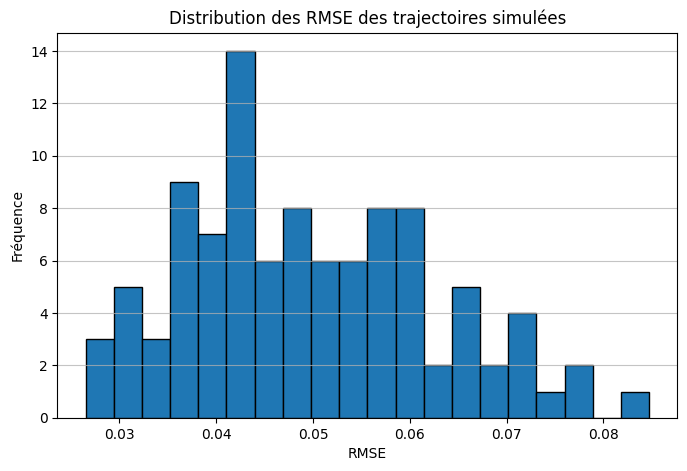


--- Analyse des RMSE pour les simulations ---
Nombre de simulations : 100
Moyenne des RMSE : 0.049653
Écart type des RMSE : 0.012572
Min RMSE : 0.026497
Max RMSE : 0.084734


In [ ]:
# --- Analyse des RMSE pour les simulations ---

# Visualiser la distribution des RMSE

plt.figure(figsize=(8, 5))
plt.hist(simulated_rmse_list, bins=20, edgecolor='black')
plt.xlabel('RMSE')
plt.ylabel('Fréquence')
plt.title('Distribution des RMSE des trajectoires simulées')
plt.grid(axis='y', alpha=0.75)
plt.show()

print("\n--- Analyse des RMSE pour les simulations ---")
print(f"Nombre de simulations : {n_simulations}")
print(f"Moyenne des RMSE : {np.mean(simulated_rmse_list):.6f}")
print(f"Écart type des RMSE : {np.std(simulated_rmse_list):.6f}")
print(f"Min RMSE : {np.min(simulated_rmse_list):.6f}")
print(f"Max RMSE : {np.max(simulated_rmse_list):.6f}")

<ipython-input-12-1795217013>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_simulations)


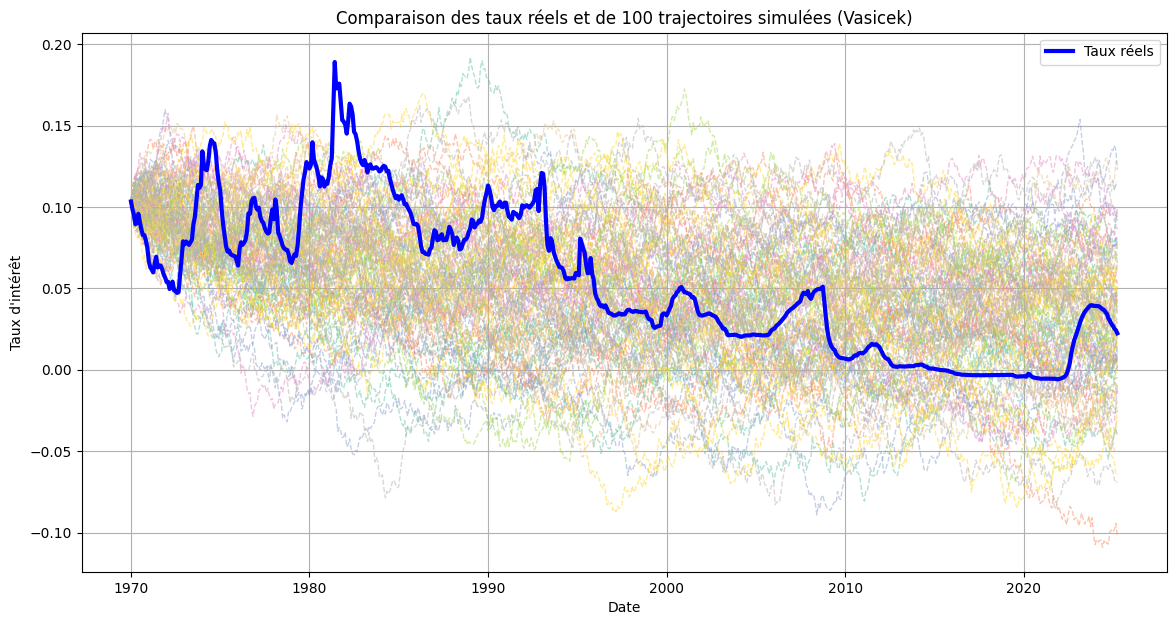

In [ ]:
|# --- Visualisation de la série réelle et des trajectoires simulées ---

plt.figure(figsize=(14, 7))


cmap_name = 'Set2'
cmap = plt.cm.get_cmap(cmap_name, n_simulations)

# Trace toutes les trajectoires simulées en premier
for i, trajectory in enumerate(simulated_trajectories):
    color = cmap(i)

    plt.plot(dates_real, trajectory, linestyle='--', alpha=0.5, color=color, linewidth=1)

plt.plot(dates_real, r_real, label='Taux réels', color='blue', linewidth=3)

plt.xlabel('Date')
plt.ylabel('Taux d\'intérêt')
plt.title(f'Comparaison des taux réels et de {n_simulations} trajectoires simulées (Vasicek)')


plt.legend()

plt.grid(True)
plt.show()


Moyenne des trajectoires simulées calculée.


<ipython-input-13-747298882>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_simulations)


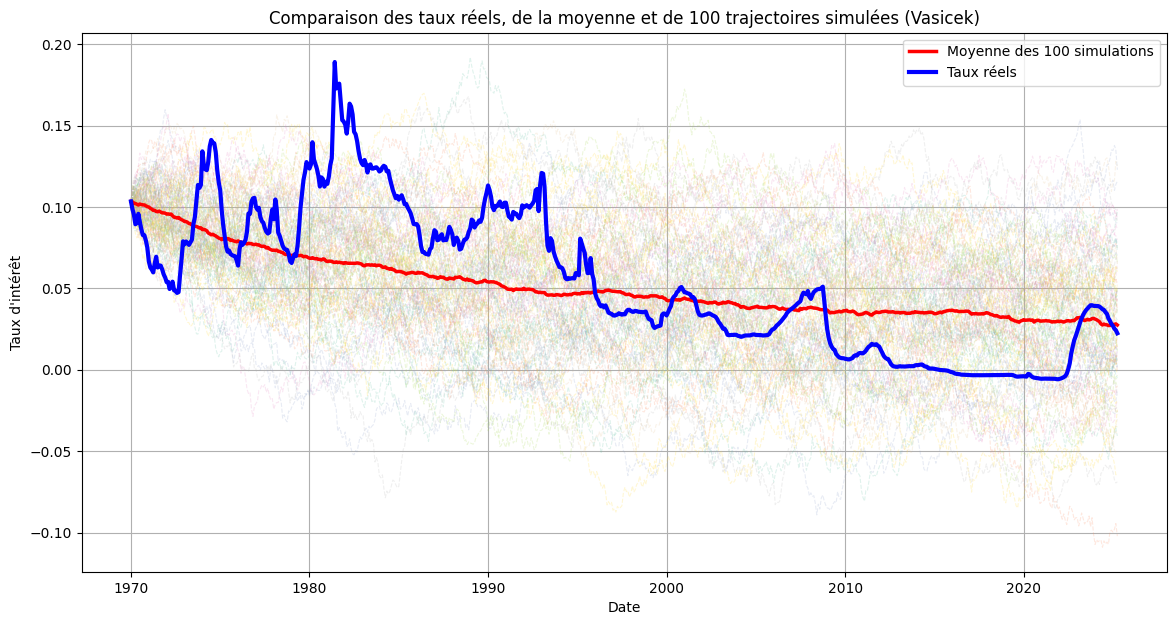

In [ ]:
# --- Calcul de la moyenne des trajectoires simulées ---

# Nous pouvons la convertir en un tableau numpy 2D où chaque ligne est une simulation
simulated_trajectories_np = np.array(simulated_trajectories)

mean_simulated_trajectory = np.mean(simulated_trajectories_np, axis=0)

print("\nMoyenne des trajectoires simulées calculée.")


# --- Visualisation de la série réelle, des trajectoires simulées et de la moyenne ---

plt.figure(figsize=(14, 7))

cmap_name = 'Set2'
cmap = plt.cm.get_cmap(cmap_name, n_simulations)

for i, trajectory in enumerate(simulated_trajectories):
    color = cmap(i)
    plt.plot(dates_real, trajectory, linestyle='--', alpha=0.2, color=color, linewidth=0.8) # Diminuez l'alpha et linewidth pour les simulations individuelles

# Trace la moyenne des trajectoires simulées
plt.plot(dates_real, mean_simulated_trajectory, label=f'Moyenne des {n_simulations} simulations', color='red', linestyle='-', linewidth=2.5) # Couleur distincte et ligne plus épaisse

# Trace la série réelle APRES les simulations et la moyenne pour qu'elle soit au premier plan
plt.plot(dates_real, r_real, label='Taux réels', color='blue', linewidth=3) # Conservez une bonne épaisseur pour la courbe réelle


plt.xlabel('Date')
plt.ylabel('Taux d\'intérêt')
plt.title(f'Comparaison des taux réels, de la moyenne et de {n_simulations} trajectoires simulées (Vasicek)')

# Ajouter la légende
plt.legend()

plt.grid(True)
plt.show()